# ARC-AGI-2 Meta-Learning Approach

## Overview
This notebook implements a meta-learning approach for the ARC-AGI-2 competition. The goal is to create an algorithm that can quickly adapt to novel abstract reasoning tasks with just a few examples.

## Imports

In [29]:
# Standard libraries
import os
import json
import time
import random
import copy
import numpy as np
import matplotlib.pyplot as plt
from typing import List, Dict, Tuple, Any, Optional, Union
from collections import defaultdict

# Deep learning
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

# Progress monitoring
from tqdm.notebook import tqdm

# Set random seeds for reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Print GPU info
if torch.cuda.is_available():
    print(f"Using GPU: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")
else:
    print("No GPU available, using CPU")

Using device: cuda
Using GPU: NVIDIA L4
GPU Memory: 23.92 GB


## Data Preparation

In [19]:
def load_data(filepath):
    """Load ARC tasks from a JSON file."""
    with open(filepath, 'r') as f:
        return json.load(f)

def load_solutions(filepath):
    """Load ARC solutions from a JSON file."""
    with open(filepath, 'r') as f:
        return json.load(f)

# Load training data with Kaggle paths
train_challenges = load_data('/kaggle/input/arc-prize-2025/arc-agi_training_challenges.json')
train_solutions = load_solutions('/kaggle/input/arc-prize-2025/arc-agi_training_solutions.json')

# Load evaluation data
eval_challenges = load_data('/kaggle/input/arc-prize-2025/arc-agi_evaluation_challenges.json')
eval_solutions = load_solutions('/kaggle/input/arc-prize-2025/arc-agi_evaluation_solutions.json')

# Load test data (will be replaced during submission)
test_challenges = load_data('/kaggle/input/arc-prize-2025/arc-agi_test_challenges.json')

print(f"Loaded {len(train_challenges)} training tasks")
print(f"Loaded {len(eval_challenges)} evaluation tasks")
print(f"Loaded {len(test_challenges)} test tasks")

Loaded 1000 training tasks
Loaded 120 evaluation tasks
Loaded 240 test tasks


## Inspect Data Structures

In [20]:
def print_data_structure(data, max_depth=3, indent=0, current_depth=0):
    """Print the structure of nested data."""
    if current_depth >= max_depth:
        print(" " * indent + "...")
        return
    
    if isinstance(data, dict):
        print(" " * indent + "{")
        for key, value in list(data.items())[:3]:  # Limit to first 3 items
            print(" " * (indent + 2) + f"{repr(key)}: ", end="")
            print_data_structure(value, max_depth, 0, current_depth + 1)
        if len(data) > 3:
            print(" " * (indent + 2) + "... and " + str(len(data) - 3) + " more items")
        print(" " * indent + "}")
    elif isinstance(data, list):
        if len(data) == 0:
            print("[]")
        else:
            print(" " * indent + "[")
            for item in data[:3]:  # Limit to first 3 items
                print(" " * (indent + 2), end="")
                print_data_structure(item, max_depth, 0, current_depth + 1)
            if len(data) > 3:
                print(" " * (indent + 2) + "... and " + str(len(data) - 3) + " more items")
            print(" " * indent + "]")
    else:
        print(repr(data))

def inspect_task_structure(task_id, task, verbose=True):
    """Print the structure of a task to understand its format."""
    if verbose:
        print(f"Task ID: {task_id}")
        print("Task keys:", list(task.keys()))
        
        print("\nTrain data:")
        for i, pair in enumerate(task['train']):
            print(f"  Pair {i+1}:")
            print(f"    Input shape: {np.array(pair['input']).shape}")
            print(f"    Output shape: {np.array(pair['output']).shape}")
    
    # Inspect test data more carefully
    test_data = task['test']
    if verbose:
        print("\nTest data type:", type(test_data))
    
    if isinstance(test_data, list):
        # Check if it's a direct grid (list of lists of integers)
        if all(isinstance(item, list) and all(isinstance(x, int) for x in item) for item in test_data):
            if verbose:
                print(f"  Test input is a grid with shape: {np.array(test_data).shape}")
            return {'type': 'direct_grid', 'shape': np.array(test_data).shape}
        # Check if it's a list of test cases (dictionaries)
        elif all(isinstance(item, dict) for item in test_data):
            if verbose:
                print(f"  Test has {len(test_data)} cases")
                for i, test_case in enumerate(test_data):
                    print(f"    Case {i+1} keys: {list(test_case.keys())}")
                    if 'input' in test_case:
                        print(f"    Input shape: {np.array(test_case['input']).shape}")
            return {'type': 'multiple_cases', 'count': len(test_data)}
    elif isinstance(test_data, dict):
        if verbose:
            print(f"  Test keys: {list(test_data.keys())}")
            if 'input' in test_data:
                print(f"  Test input shape: {np.array(test_data['input']).shape}")
        return {'type': 'dict', 'keys': list(test_data.keys())}
    
    if verbose:
        print(f"  Unrecognized test data type: {type(test_data)}")
    return {'type': 'unknown'}

def extract_test_input(task):
    """Extract test input grid(s) from a task, handling different formats."""
    test_data = task['test']
    
    if isinstance(test_data, list):
        # Check if it's a direct grid (list of lists of integers)
        if len(test_data) > 0 and all(isinstance(item, list) for item in test_data):
            if all(isinstance(x, int) for x in test_data[0]):
                return [test_data]  # Return as a list containing one grid
        
        # Check if it's a list of test cases (dictionaries)
        if all(isinstance(item, dict) for item in test_data):
            return [test_case['input'] for test_case in test_data if 'input' in test_case]
    
    # If it's a dictionary with an input key
    elif isinstance(test_data, dict) and 'input' in test_data:
        return [test_data['input']]
    
    # Fallback
    print(f"Warning: Could not extract test input from task, unknown format: {type(test_data)}")
    return []

def extract_solution_grid(solution):
    """Extract solution grid(s) from solution data, handling different formats.
    Returns a list of grids."""
    if isinstance(solution, list):
        # If it's already a grid (list of lists of integers)
        if len(solution) > 0 and isinstance(solution[0], list):
            if all(isinstance(x, int) for x in solution[0]):
                return [solution]  # Return as a list containing one grid
            
            # If it's a list containing a grid
            if len(solution) == 1 and isinstance(solution[0], list) and len(solution[0]) > 0 and isinstance(solution[0][0], list):
                if all(isinstance(x, int) for x in solution[0][0]):
                    return [solution[0]]  # Return the inner grid
        
        # If it's a list of dictionaries with output keys
        if all(isinstance(item, dict) for item in solution):
            return [item['output'] for item in solution if 'output' in item]
    
    # If it's a dictionary with an output key
    elif isinstance(solution, dict) and 'output' in solution:
        return [solution['output']]
    
    # Fallback
    print(f"Warning: Could not extract grid from solution, unknown format: {type(solution)}")
    return []

## Functions for Visualization

In [21]:
def visualize_grid(grid, title="Grid", cmap='tab10'):
    """Visualize a single grid."""
    plt.figure(figsize=(5, 5))
    cmap = plt.colormaps[cmap]
    plt.imshow(np.array(grid), cmap=cmap, vmin=0, vmax=9)
    plt.title(title)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

def visualize_task(task_id, task, solutions=None):
    """Visualize a task with its train pairs and test input."""
    plt.figure(figsize=(15, 10))
    
    # Use a colormap that's compatible with newer matplotlib versions
    cmap = plt.colormaps['tab10']
    
    # Plot train pairs
    train_pairs = task['train']
    n_train = len(train_pairs)
    
    for i, pair in enumerate(train_pairs):
        # Plot input
        plt.subplot(2, n_train + 1, i + 1)
        plt.imshow(np.array(pair['input']), cmap=cmap, vmin=0, vmax=9)
        plt.title(f"Train {i+1} Input")
        plt.axis('off')
        
        # Plot output
        plt.subplot(2, n_train + 1, n_train + i + 2)
        plt.imshow(np.array(pair['output']), cmap=cmap, vmin=0, vmax=9)
        plt.title(f"Train {i+1} Output")
        plt.axis('off')
    
    # Extract and plot test input
    plt.subplot(2, n_train + 1, n_train + 1)
    test_inputs = extract_test_input(task)
    
    if test_inputs:
        # Just show the first test input for now
        plt.imshow(np.array(test_inputs[0]), cmap=cmap, vmin=0, vmax=9)
        if len(test_inputs) > 1:
            plt.title(f"Test Input 1/{len(test_inputs)}")
        else:
            plt.title("Test Input")
    else:
        plt.text(0.5, 0.5, "No test input found", ha='center', va='center', transform=plt.gca().transAxes)
    
    plt.axis('off')
    
    # Extract and plot solution if available
    if solutions and task_id in solutions:
        plt.subplot(2, n_train + 1, 2 * (n_train + 1))
        
        solution_grids = extract_solution_grid(solutions[task_id])
        if solution_grids:
            # Just show the first solution grid for now
            plt.imshow(np.array(solution_grids[0]), cmap=cmap, vmin=0, vmax=9)
            if len(solution_grids) > 1:
                plt.title(f"Ground Truth 1/{len(solution_grids)}")
            else:
                plt.title("Ground Truth")
        else:
            plt.text(0.5, 0.5, "No solution grid found", ha='center', va='center', transform=plt.gca().transAxes)
        
        plt.axis('off')
    
    plt.suptitle(f"Task ID: {task_id}")
    plt.tight_layout()
    plt.show()

## Grid Processing Utilities

In [22]:
def get_grid_shape(grid):
    """Get the shape (height, width) of a grid."""
    if not isinstance(grid, list) or len(grid) == 0:
        raise ValueError(f"Invalid grid format: {type(grid)}")
    return len(grid), len(grid[0])

def pad_grid(grid, target_shape, pad_value=0):
    """Pad a grid to the target shape."""
    height, width = get_grid_shape(grid)
    target_height, target_width = target_shape
    
    # Create a new grid with the target shape
    padded_grid = [[pad_value for _ in range(target_width)] for _ in range(target_height)]
    
    # Copy the original grid values
    for i in range(min(height, target_height)):
        for j in range(min(width, target_width)):
            padded_grid[i][j] = grid[i][j]
    
    return padded_grid

def crop_grid(grid, target_shape):
    """Crop a grid to the target shape."""
    target_height, target_width = target_shape
    
    # Create a new grid with the target shape
    cropped_grid = [[grid[i][j] for j in range(min(len(grid[0]), target_width))] 
                    for i in range(min(len(grid), target_height))]
    
    return cropped_grid

def resize_grid(grid, target_shape, pad_value=0):
    """Resize a grid to the target shape (padding or cropping as needed)."""
    height, width = get_grid_shape(grid)
    target_height, target_width = target_shape
    
    if height > target_height or width > target_width:
        # Crop if the grid is larger than the target
        return crop_grid(grid, target_shape)
    elif height < target_height or width < target_width:
        # Pad if the grid is smaller than the target
        return pad_grid(grid, target_shape, pad_value)
    else:
        # Return as is if the shapes match
        return grid

def grid_to_tensor(grid):
    """Convert a grid to a PyTorch tensor with shape (1, H, W)."""
    # Convert to numpy array first, then to tensor
    grid_array = np.array(grid, dtype=np.float32)
    # Add channel dimension
    return torch.tensor(grid_array).unsqueeze(0)

def tensor_to_grid(tensor):
    """Convert a PyTorch tensor with shape (1, H, W) to a grid."""
    # Remove channel dimension and convert to numpy array
    grid_array = tensor.squeeze(0).detach().cpu().numpy()
    # Convert to list of lists
    return grid_array.astype(int).tolist()

def normalize_grid(grid):
    """Normalize a grid by mapping its unique values to 0, 1, 2, etc."""
    flat_grid = [val for row in grid for val in row]
    unique_values = sorted(set(flat_grid))
    value_map = {val: i for i, val in enumerate(unique_values)}
    
    normalized_grid = [[value_map[val] for val in row] for row in grid]
    return normalized_grid

def preprocess_grid(grid, max_size=30):
    """Preprocess a grid for model input."""
    # Ensure grid is a list of lists
    if not isinstance(grid, list):
        raise ValueError(f"Grid must be a list, got {type(grid)}")
    
    # Convert to numpy array for shape checking
    grid_array = np.array(grid)
    
    # Ensure grid is not too large
    if grid_array.shape[0] > max_size or grid_array.shape[1] > max_size:
        grid = resize_grid(grid, (min(grid_array.shape[0], max_size), min(grid_array.shape[1], max_size)))
    
    # Convert to tensor
    tensor = grid_to_tensor(grid)
    
    # Normalize to [0, 1]
    tensor = tensor / 9.0
    
    return tensor

def postprocess_tensor(tensor, original_shape=None):
    """Convert model output tensor to a grid format."""
    # Scale back to [0, 9]
    tensor = torch.clamp(tensor * 9.0, 0, 9)
    
    # Round to nearest integer
    tensor = torch.round(tensor)
    
    # Convert to grid
    grid = tensor_to_grid(tensor)
    
    # Resize to original shape if provided
    if original_shape:
        grid = resize_grid(grid, original_shape)
    
    return grid

## Dataset Class object for ARC Tasks

In [23]:
class ARCDataset(Dataset):
    """Dataset for ARC tasks."""
    def __init__(self, challenges, solutions=None, max_size=30):
        self.challenges = challenges
        self.solutions = solutions
        self.task_ids = list(challenges.keys())
        self.max_size = max_size
    
    def __len__(self):
        return len(self.task_ids)
    
    def __getitem__(self, idx):
        task_id = self.task_ids[idx]
        task = self.challenges[task_id]
        
        # Process train pairs
        train_data = []
        for pair in task['train']:
            input_grid = pair['input']
            output_grid = pair['output']
            
            # Preprocess grids
            try:
                input_tensor = preprocess_grid(input_grid, self.max_size)
                output_tensor = preprocess_grid(output_grid, self.max_size)
                train_data.append((input_tensor, output_tensor))
            except Exception as e:
                print(f"Error preprocessing train pair for task {task_id}: {str(e)}")
                continue
        
        # Process test input(s)
        test_inputs = []
        
        try:
            # Extract test input grids
            test_grids = extract_test_input(task)
            for grid in test_grids:
                test_inputs.append(preprocess_grid(grid, self.max_size))
        except Exception as e:
            print(f"Error processing test input for task {task_id}: {str(e)}")
        
        # Process test output(s) if available
        test_outputs = []
        
        if self.solutions and task_id in self.solutions:
            try:
                # Extract solution grids
                solution_grids = extract_solution_grid(self.solutions[task_id])
                for grid in solution_grids:
                    test_outputs.append(preprocess_grid(grid, self.max_size))
            except Exception as e:
                print(f"Error processing solution for task {task_id}: {str(e)}")
        
        # Fill remaining outputs with None if needed
        while len(test_outputs) < len(test_inputs):
            test_outputs.append(None)
        
        # If no test inputs were processed, add a placeholder
        if len(test_inputs) == 0:
            print(f"Warning: No valid test inputs found for task {task_id}")
            test_inputs.append(torch.zeros((1, 1, 1)))
            test_outputs.append(None)
        
        return task_id, train_data, test_inputs, test_outputs

def collate_arc_batch(batch):
    """Custom collate function for ARC batches."""
    # Each element in batch is (task_id, train_data, test_inputs, test_outputs)
    task_ids = [item[0] for item in batch]
    train_data_list = [item[1] for item in batch]
    test_inputs_list = [item[2] for item in batch]
    test_outputs_list = [item[3] for item in batch]
    
    return task_ids, train_data_list, test_inputs_list, test_outputs_list

## Data Analysis and Exploration


Analyzing training data structure:
Sample train challenge structure:
{
  'train': [
  {
  'input': ...
  'output': ...
}
  {
  'input': ...
  'output': ...
}
]
  'test': [
  {
  'input': ...
}
]
}

Sample train solution structure:
[
  [
  [
  ...
  ...
  ...
  ... and 3 more items
]
  [
  ...
  ...
  ...
  ... and 3 more items
]
  [
  ...
  ...
  ...
  ... and 3 more items
]
  ... and 3 more items
]
]

Visualizing sample training tasks:

Sample Task 1:
Task ID: 00576224
Task keys: ['train', 'test']

Train data:
  Pair 1:
    Input shape: (2, 2)
    Output shape: (6, 6)
  Pair 2:
    Input shape: (2, 2)
    Output shape: (6, 6)

Test data type: <class 'list'>
  Test has 1 cases
    Case 1 keys: ['input']
    Input shape: (2, 2)


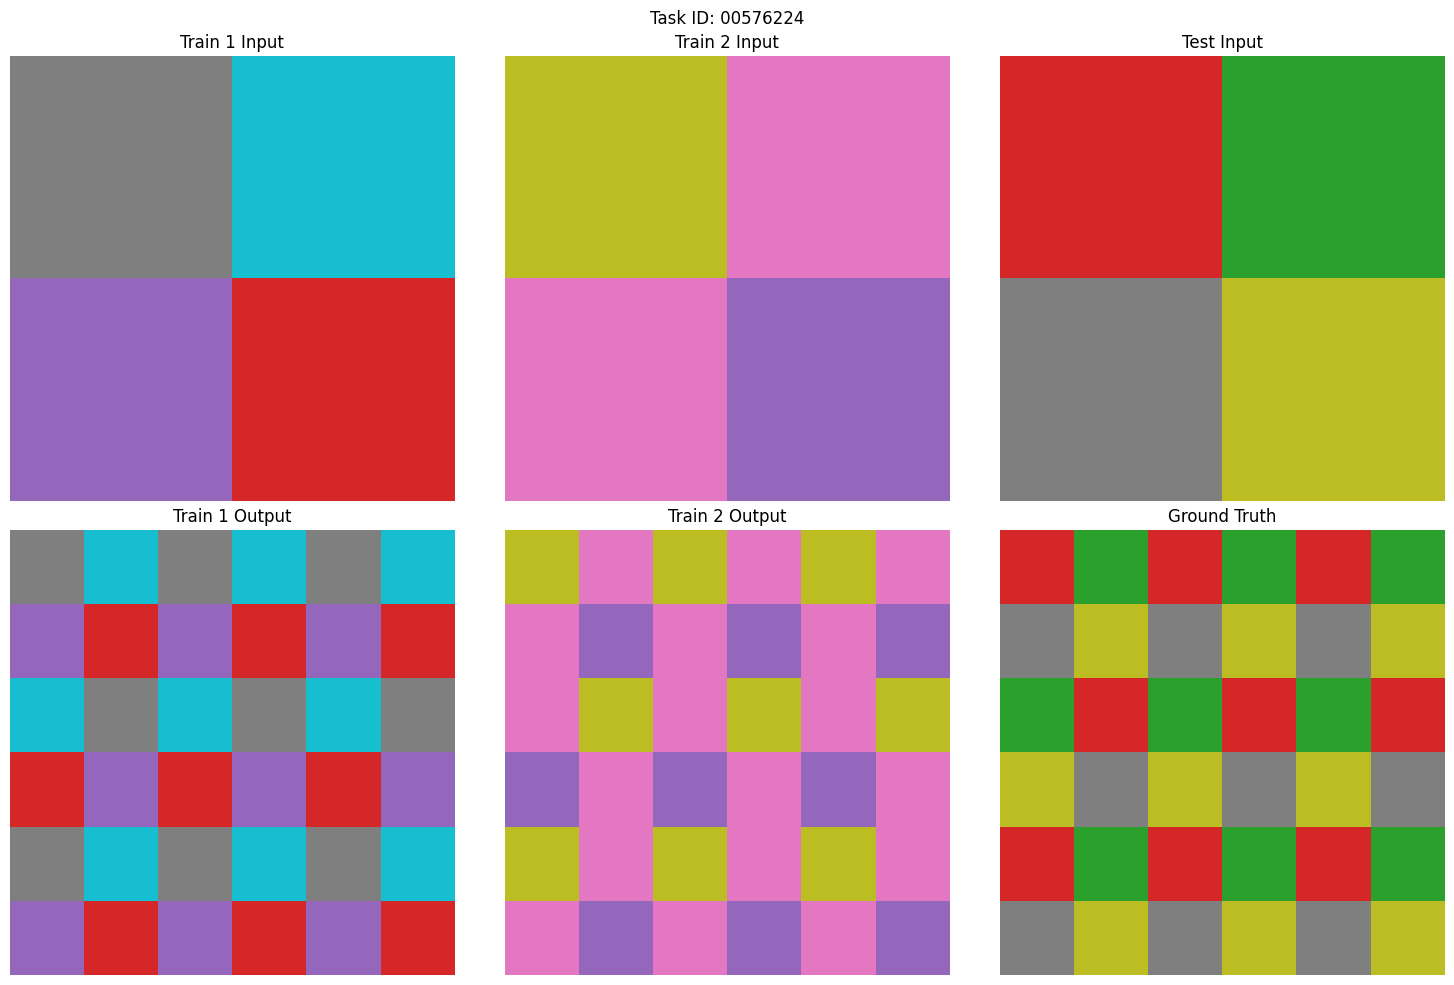


Sample Task 2:
Task ID: 007bbfb7
Task keys: ['train', 'test']

Train data:
  Pair 1:
    Input shape: (3, 3)
    Output shape: (9, 9)
  Pair 2:
    Input shape: (3, 3)
    Output shape: (9, 9)
  Pair 3:
    Input shape: (3, 3)
    Output shape: (9, 9)
  Pair 4:
    Input shape: (3, 3)
    Output shape: (9, 9)
  Pair 5:
    Input shape: (3, 3)
    Output shape: (9, 9)

Test data type: <class 'list'>
  Test has 1 cases
    Case 1 keys: ['input']
    Input shape: (3, 3)


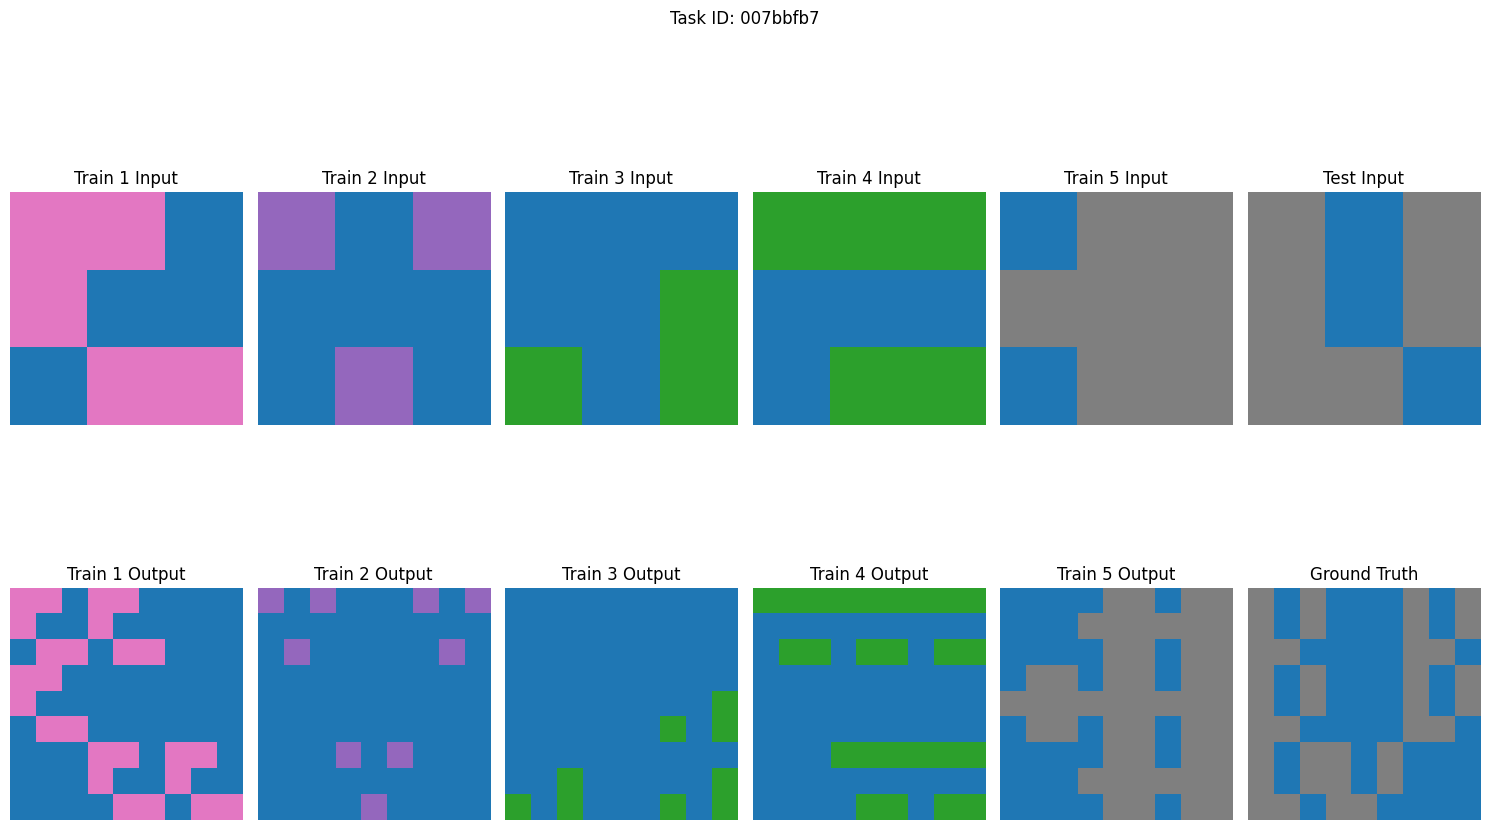


Sample Task 3:
Task ID: 009d5c81
Task keys: ['train', 'test']

Train data:
  Pair 1:
    Input shape: (14, 14)
    Output shape: (14, 14)
  Pair 2:
    Input shape: (14, 14)
    Output shape: (14, 14)
  Pair 3:
    Input shape: (14, 14)
    Output shape: (14, 14)
  Pair 4:
    Input shape: (14, 14)
    Output shape: (14, 14)
  Pair 5:
    Input shape: (14, 14)
    Output shape: (14, 14)

Test data type: <class 'list'>
  Test has 1 cases
    Case 1 keys: ['input']
    Input shape: (14, 14)


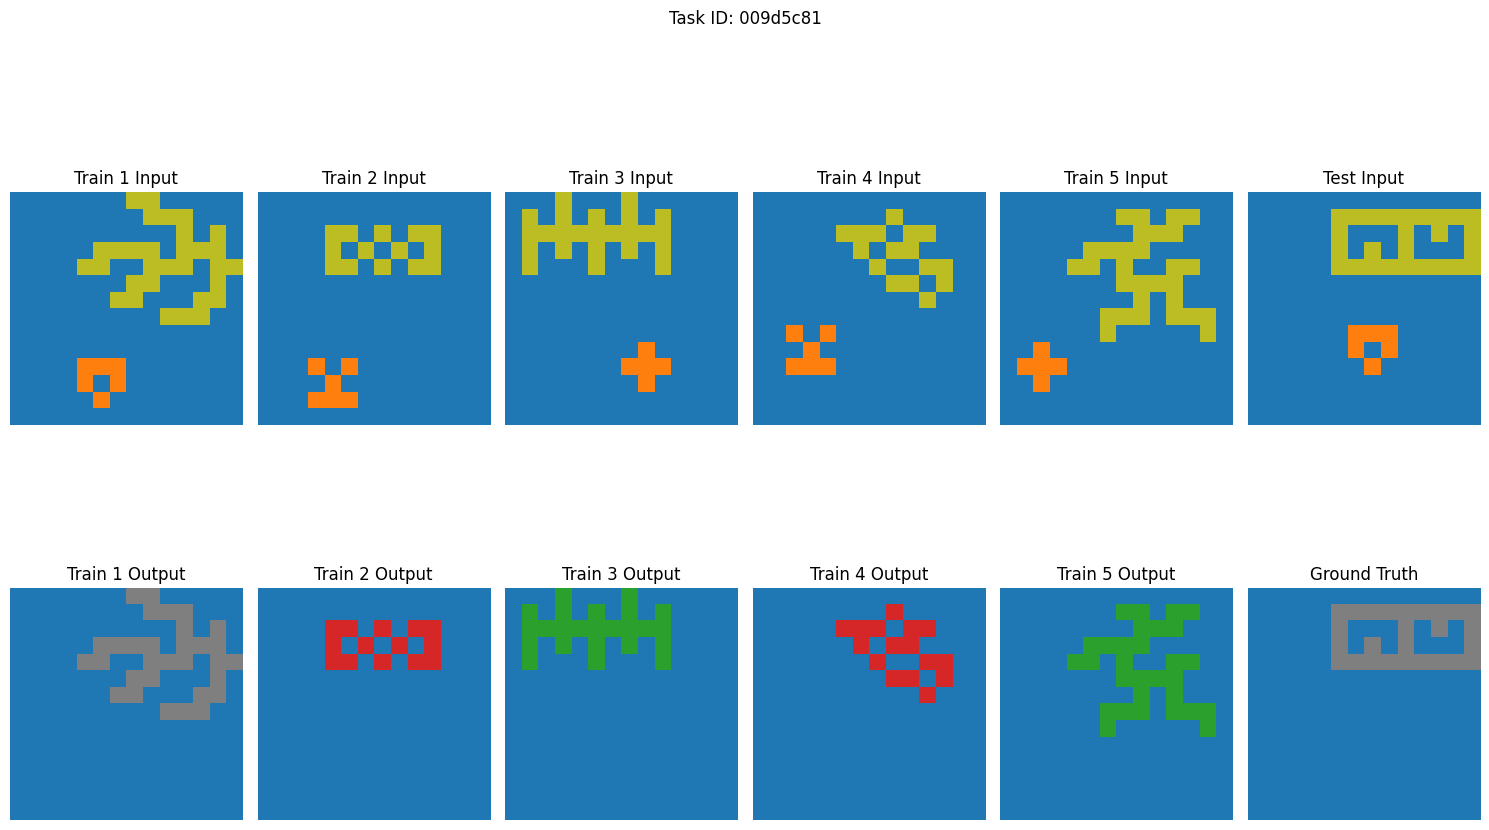


Analyzing test input formats across tasks:
Test input format distribution:
  multiple_cases: 50 tasks

Analyzing solution structures:
Solution structure distribution:
  list_containing_grid: 49 tasks
  direct_grid: 1 tasks

Testing data loading:
Batch with 2 tasks
  Task 1 (ID: 00576224):
    Number of train pairs: 2
    Number of test inputs: 1
    Number of test outputs: 1
    First train pair shapes: input (1, 2, 2), output (1, 6, 6)
    First test input shape: (1, 2, 2)
    First test output shape: (1, 6, 6)
  Task 2 (ID: 007bbfb7):
    Number of train pairs: 5
    Number of test inputs: 1
    Number of test outputs: 1
    First train pair shapes: input (1, 3, 3), output (1, 9, 9)
    First test input shape: (1, 3, 3)
    First test output shape: (1, 9, 9)


In [24]:
# Analyze the structure of training tasks and solutions
print("\nAnalyzing training data structure:")
print("Sample train challenge structure:")
if list(train_challenges.keys()):
    sample_task_id = list(train_challenges.keys())[0]
    print_data_structure(train_challenges[sample_task_id])

    print("\nSample train solution structure:")
    if sample_task_id in train_solutions:
        print_data_structure(train_solutions[sample_task_id])
    else:
        print("No solution found for sample task")

# Visualize a few sample tasks
print("\nVisualizing sample training tasks:")
for i, task_id in enumerate(list(train_challenges.keys())[:3]):
    print(f"\nSample Task {i+1}:")
    try:
        inspect_task_structure(task_id, train_challenges[task_id])
        visualize_task(task_id, train_challenges[task_id], train_solutions)
    except Exception as e:
        print(f"Error visualizing task: {str(e)}")

# Analyze test input formats
print("\nAnalyzing test input formats across tasks:")
test_formats = {}
for i, task_id in enumerate(list(train_challenges.keys())[:50]):  # Sample first 50 tasks
    try:
        task = train_challenges[task_id]
        format_info = inspect_task_structure(task_id, task, verbose=False)
        format_type = format_info['type']
        
        if format_type not in test_formats:
            test_formats[format_type] = 0
        test_formats[format_type] += 1
    except Exception:
        continue

print("Test input format distribution:")
for format_type, count in test_formats.items():
    print(f"  {format_type}: {count} tasks")

# Analyze solution structures
print("\nAnalyzing solution structures:")
solution_types = {}
for i, task_id in enumerate(list(train_solutions.keys())[:50]):  # Sample first 50 tasks
    solution = train_solutions[task_id]
    
    # Determine the solution type
    if isinstance(solution, list):
        if len(solution) == 0:
            solution_type = "empty_list"
        elif len(solution) == 1 and isinstance(solution[0], list) and all(isinstance(row, list) for row in solution[0]):
            solution_type = "list_containing_grid"
        elif all(isinstance(item, list) for item in solution):
            solution_type = "direct_grid"
        elif all(isinstance(item, dict) for item in solution):
            solution_type = "list_of_dicts"
        else:
            solution_type = "other_list"
    elif isinstance(solution, dict):
        solution_type = "dict"
    else:
        solution_type = "other"
    
    if solution_type not in solution_types:
        solution_types[solution_type] = 0
    solution_types[solution_type] += 1

print("Solution structure distribution:")
for solution_type, count in solution_types.items():
    print(f"  {solution_type}: {count} tasks")

# Test the dataset
print("\nTesting data loading:")
sample_dataset = ARCDataset(
    {k: train_challenges[k] for k in list(train_challenges.keys())[:5]},
    {k: train_solutions[k] for k in list(train_solutions.keys())[:5]}
)

sample_loader = DataLoader(
    sample_dataset,
    batch_size=2,
    shuffle=False,
    collate_fn=collate_arc_batch
)

for task_ids, train_data_list, test_inputs_list, test_outputs_list in sample_loader:
    print(f"Batch with {len(task_ids)} tasks")
    for i, (task_id, train_data, test_inputs, test_outputs) in enumerate(zip(task_ids, train_data_list, test_inputs_list, test_outputs_list)):
        print(f"  Task {i+1} (ID: {task_id}):")
        print(f"    Number of train pairs: {len(train_data)}")
        print(f"    Number of test inputs: {len(test_inputs)}")
        print(f"    Number of test outputs: {len(test_outputs)}")
        
        # Print shapes of the first train pair and test input/output
        if train_data:
            input_tensor, output_tensor = train_data[0]
            print(f"    First train pair shapes: input {tuple(input_tensor.shape)}, output {tuple(output_tensor.shape)}")
        
        if test_inputs:
            print(f"    First test input shape: {tuple(test_inputs[0].shape)}")
        
        if test_outputs and test_outputs[0] is not None:
            print(f"    First test output shape: {tuple(test_outputs[0].shape)}")
        else:
            print("    No test output available")
    
    # Only process one batch for this example
    break

## Analysis of Submission Format

In [25]:
print("\nExpected submission format:")
submission_example = {
    "task_id_1": [{"attempt_1": [[0, 0], [0, 0]], "attempt_2": [[1, 1], [0, 0]]}],
    "task_id_2": [
        {"attempt_1": [[0, 0], [0, 0]], "attempt_2": [[0, 0], [0, 0]]},
        {"attempt_1": [[0, 0], [0, 0]], "attempt_2": [[0, 0], [0, 0]]}
    ]
}

print_data_structure(submission_example)
print("Each task ID maps to a list of prediction objects.")
print("Each prediction object contains 'attempt_1' and 'attempt_2' for two prediction attempts.")
print("For tasks with multiple test inputs, the list contains multiple prediction objects.")


Expected submission format:
{
  'task_id_1': [
  {
  'attempt_1': ...
  'attempt_2': ...
}
]
  'task_id_2': [
  {
  'attempt_1': ...
  'attempt_2': ...
}
  {
  'attempt_1': ...
  'attempt_2': ...
}
]
}
Each task ID maps to a list of prediction objects.
Each prediction object contains 'attempt_1' and 'attempt_2' for two prediction attempts.
For tasks with multiple test inputs, the list contains multiple prediction objects.


## Neural Network Models for Meta-Learning

In [39]:
# Helper function to ensure consistent dimensions
def ensure_same_dimensions(prediction, target):
    """
    Ensures prediction and target tensors have the same dimensions
    for proper loss calculation.
    """
    # Check if dimensions match
    if prediction.dim() != target.dim():
        # If prediction has extra channel dimension [batch, channel, height, width]
        # but target is [batch, height, width]
        if prediction.dim() == 4 and target.dim() == 3:
            # Add channel dimension to target
            target = target.unsqueeze(1)
        # If target has extra channel dimension
        elif prediction.dim() == 3 and target.dim() == 4:
            # Add channel dimension to prediction
            prediction = prediction.unsqueeze(1)
    
    return prediction, target

class GridEncoder(nn.Module):
    """Encodes a grid into a latent representation."""
    def __init__(self, input_channels=1, latent_dim=128):
        super(GridEncoder, self).__init__()
        
        # CNN layers for grid encoding
        self.conv1 = nn.Conv2d(input_channels, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2)
        
        # Adaptive pooling to handle variable-sized inputs - this is crucial
        self.adaptive_pool = nn.AdaptiveAvgPool2d((4, 4))
        
        # Fully connected layer to latent space
        self.fc = nn.Linear(64 * 4 * 4, latent_dim)
        
    def forward(self, x):
        # Ensure the input has 4 dimensions [batch, channel, height, width]
        if len(x.shape) == 3:  # If it's [channel, height, width], add batch dimension
            x = x.unsqueeze(0)
        
        # Apply convolutions
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = F.relu(self.conv3(x))
        
        # Apply adaptive pooling to get fixed size regardless of input dimensions
        x = self.adaptive_pool(x)
        
        # Flatten the tensor
        x = x.view(x.size(0), -1)
        
        # Project to latent space
        x = self.fc(x)
        
        return x

class GridDecoder(nn.Module):
    """Decodes a latent representation back to a grid."""
    def __init__(self, latent_dim=128, output_channels=1, output_size=(10, 10)):
        super(GridDecoder, self).__init__()
        self.output_size = output_size
        
        # Fully connected layer from latent to initial feature map
        self.fc = nn.Linear(latent_dim, 64 * 4 * 4)
        
        # Transposed convolution layers
        self.deconv1 = nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.deconv2 = nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1)
        
        # Final convolution to get the desired number of channels
        self.conv_out = nn.Conv2d(16, output_channels, kernel_size=3, padding=1)
        
        # Adaptive convolutional layers to resize to desired output dimensions
        self.upsample = nn.Upsample(size=output_size, mode='bilinear', align_corners=False)
        
    def forward(self, x):
        # Expected input shape: (batch_size, latent_dim)
        
        # Project from latent space and reshape
        x = self.fc(x)
        x = x.view(x.size(0), 64, 4, 4)
        
        # Deconvolution layers
        x = F.relu(self.deconv1(x))
        x = F.relu(self.deconv2(x))
        
        # Final convolution
        x = self.conv_out(x)
        
        # Resize to desired output dimensions
        x = self.upsample(x)
        
        # Apply sigmoid to get values in [0, 1]
        x = torch.sigmoid(x)
        
        return x

class TransformationNetwork(nn.Module):
    """Network that learns the transformation between input and output grids."""
    def __init__(self, encoder_dim=128, hidden_dim=256, max_output_size=(30, 30)):
        super(TransformationNetwork, self).__init__()
        
        self.encoder = GridEncoder(input_channels=1, latent_dim=encoder_dim)
        
        # Size prediction network to predict the output grid size
        self.size_predictor = nn.Sequential(
            nn.Linear(encoder_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 2)  # Predict height and width
        )
        
        # Transformation network to process encoded inputs
        self.transform_net = nn.Sequential(
            nn.Linear(encoder_dim * 2, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim, encoder_dim)
        )
        
        # Dynamic decoder that will be instantiated based on predicted size
        self.decoder = None
        self.max_output_size = max_output_size
        
    def predict_output_size(self, encoded_input, encoded_output=None):
        """Predict the output grid size based on the encoded input."""
        # For training, we can use the actual output size
        if encoded_output is not None:
            # This is just a placeholder during training
            # We'll use the actual output size
            return None
        
        # For inference, predict the output size
        size_logits = self.size_predictor(encoded_input)
        
        # Ensure the predicted size is reasonable
        predicted_size = torch.clamp(
            torch.round(torch.sigmoid(size_logits) * torch.tensor([30.0, 30.0]).to(encoded_input.device)),
            min=1, max=30
        ).int()
        
        return (predicted_size[0].item(), predicted_size[1].item())
    
    def forward(self, input_grid, output_grid=None, output_size=None):
        # Encode the input
        encoded_input = self.encoder(input_grid)
        
        if output_grid is not None:
            # Training mode
            encoded_output = self.encoder(output_grid)
            concat_encoding = torch.cat([encoded_input, encoded_output], dim=1)
            
            # Learn the transformation
            transformation = self.transform_net(concat_encoding)
            
            # For training, we'll use the actual output size
            actual_size = (output_grid.shape[-2], output_grid.shape[-1])  # Use -2, -1 to handle different shapes
            
            # Create decoder if it doesn't exist or if output size changed
            if self.decoder is None or getattr(self.decoder, 'output_size', None) != actual_size:
                self.decoder = GridDecoder(
                    latent_dim=encoded_input.shape[1],
                    output_size=actual_size
                ).to(input_grid.device)
            
            # Apply transformation to get predicted output encoding
            predicted_output_encoding = encoded_input + transformation
            
            # Decode to get predicted output
            predicted_output = self.decoder(predicted_output_encoding)
            
            return predicted_output
        
        else:
            # Inference mode
            # Predict output size if not provided
            if output_size is None:
                output_size = self.predict_output_size(encoded_input)
            
            # Create decoder for the predicted/provided size
            self.decoder = GridDecoder(
                latent_dim=encoded_input.shape[1],
                output_size=output_size
            ).to(input_grid.device)
            
            # For prediction, return the encoded input
            return encoded_input

class MAML(nn.Module):
    """Model-Agnostic Meta-Learning for quick adaptation to new tasks."""
    def __init__(self, model, inner_lr=0.01, meta_lr=0.001):
        super(MAML, self).__init__()
        self.model = model
        self.inner_lr = inner_lr
        self.meta_optimizer = optim.Adam(self.model.parameters(), lr=meta_lr)
        
    def adapt(self, support_data, num_steps=5):
        """Adapt the model to a new task using the support data."""
        # Create a copy of the model for adaptation
        adapted_model = copy.deepcopy(self.model)
        adapted_model.train()
        
        # Set up an optimizer for adaptation
        optimizer = optim.SGD(adapted_model.parameters(), lr=self.inner_lr)
        
        # Collect output sizes for decoder creation
        output_sizes = []
        for input_grid, output_grid in support_data:
            if input_grid is None or output_grid is None:
                continue
                
            # Get the actual grid dimensions (handle different tensor shapes)
            if len(output_grid.shape) >= 3:  # [batch/channel, height, width] or [batch, channel, height, width]
                output_sizes.append((output_grid.shape[-2], output_grid.shape[-1]))  # Use last two dimensions
            elif len(output_grid.shape) == 2:  # [height, width]
                output_sizes.append((output_grid.shape[0], output_grid.shape[1]))
            else:
                # Skip invalid shapes
                continue
        
        # Use most common output size for efficiency
        if not output_sizes:
            # Default fallback if no valid sizes
            most_common_size = (10, 10)
        else:
            output_size_counts = {}
            for size in output_sizes:
                if size not in output_size_counts:
                    output_size_counts[size] = 0
                output_size_counts[size] += 1
            most_common_size = max(output_size_counts.items(), key=lambda x: x[1])[0]
        
        # Create decoder for this adaptation session
        adapted_model.decoder = GridDecoder(
            latent_dim=adapted_model.encoder.fc.out_features,
            output_size=most_common_size
        ).to(device)
        
        # Filter out invalid support data
        valid_support_data = []
        for input_grid, output_grid in support_data:
            if input_grid is not None and output_grid is not None:
                valid_support_data.append((input_grid, output_grid))
        
        if not valid_support_data:
            return adapted_model  # Return unadapted model if no valid data
        
        for _ in range(num_steps):
            total_loss = 0
            
            for input_grid, output_grid in valid_support_data:
                try:
                    # Forward pass
                    predicted_output = adapted_model(input_grid, output_grid)
                    
                    # Ensure dimensions match for loss calculation
                    predicted_output, output_grid = ensure_same_dimensions(predicted_output, output_grid)
                    
                    # Compute loss
                    loss = F.mse_loss(predicted_output, output_grid)
                    
                    # Backward pass and optimization
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()
                    
                    total_loss += loss.item()
                except Exception as e:
                    continue  # Skip on error
        
        return adapted_model
    
    def meta_learn(self, task_batch, num_inner_steps=5):
        """Perform meta-learning on a batch of tasks."""
        meta_loss = 0
        count = 0
        
        for support_data, query_data in task_batch:
            # Skip if no support or query data
            if not support_data or not query_data:
                continue
                
            try:
                # Adapt the model to the task
                adapted_model = self.adapt(support_data, num_steps=num_inner_steps)
                
                # Compute loss on query set with the adapted model
                query_loss = 0
                query_count = 0
                
                for input_grid, output_grid in query_data:
                    # Forward pass with adapted model
                    predicted_output = adapted_model(input_grid, output_grid)
                    
                    # Ensure dimensions match for loss calculation
                    predicted_output, output_grid = ensure_same_dimensions(predicted_output, output_grid)
                    
                    # Compute loss
                    loss = F.mse_loss(predicted_output, output_grid)
                    query_loss += loss.item()
                    query_count += 1
                
                # Average query loss
                if query_count > 0:
                    query_loss = query_loss / query_count
                    meta_loss += query_loss
                    count += 1
            except Exception as e:
                print(f"Error in meta_learn: {str(e)}")
                continue  # Skip on error
        
        # Average meta loss
        if count > 0:
            meta_loss = meta_loss / count
            
            # Make sure we have a tensor, not just a float value
            meta_loss_tensor = torch.tensor(meta_loss, requires_grad=True, device=device)
            
            # Update the model with the meta-gradient
            self.meta_optimizer.zero_grad()
            meta_loss_tensor.backward()
            self.meta_optimizer.step()
            
            return meta_loss
        else:
            # Return 0 if no tasks were processed
            return 0.0
    
    def predict(self, support_data, query_input, num_adaptation_steps=10, attempt=1):
        """Make a prediction for a query input after adapting on support data."""
        # Adapt the model to the task
        adapted_model = self.adapt(support_data, num_steps=num_adaptation_steps)
        adapted_model.eval()
        
        with torch.no_grad():
            # Encode the query input
            encoded_query = adapted_model.encoder(query_input)
            
            # Compute average transformation from support data
            avg_transformation = torch.zeros_like(encoded_query)
            count = 0
            
            # Try to infer the output size from the support data
            output_sizes = []
            size_counts = {}
            
            for input_grid, output_grid in support_data:
                if input_grid is None or output_grid is None:
                    continue
                
                try:
                    # Get the actual grid dimensions (handle different tensor shapes)
                    if len(output_grid.shape) >= 3:  # [batch/channel, height, width] or [batch, channel, height, width]
                        output_size = (output_grid.shape[-2], output_grid.shape[-1])  # Use last two dimensions
                    elif len(output_grid.shape) == 2:  # [height, width]
                        output_size = (output_grid.shape[0], output_grid.shape[1])
                    else:
                        continue  # Skip invalid shapes
                    
                    output_sizes.append(output_size)
                    
                    if output_size not in size_counts:
                        size_counts[output_size] = 0
                    size_counts[output_size] += 1
                    
                    # Encode support input and output
                    encoded_input = adapted_model.encoder(input_grid)
                    encoded_output = adapted_model.encoder(output_grid)
                    
                    # Compute transformation
                    concat_encoding = torch.cat([encoded_input, encoded_output], dim=1)
                    transformation = adapted_model.transform_net(concat_encoding)
                    
                    avg_transformation += transformation
                    count += 1
                except Exception as e:
                    continue
            
            if count > 0:
                avg_transformation /= count
            
            # Apply the transformation
            predicted_encoding = encoded_query + avg_transformation
            
            # Choose output size based on attempt
            if not size_counts:
                predicted_size = (10, 10)  # Default fallback
            elif attempt == 1:
                # For first attempt, use the most common size in support data
                predicted_size = max(size_counts.items(), key=lambda x: x[1])[0]
            else:
                # For second attempt, use a different approach
                # If we have multiple sizes, choose the second most common
                # Otherwise, predict a size based on the input
                if len(size_counts) > 1:
                    # Sort sizes by count in descending order
                    sorted_sizes = sorted(size_counts.items(), key=lambda x: x[1], reverse=True)
                    predicted_size = sorted_sizes[1][0]  # Second most common
                else:
                    # Predict a size using the size predictor
                    size_logits = adapted_model.size_predictor(encoded_query)
                    predicted_size = torch.clamp(
                        torch.round(torch.sigmoid(size_logits) * torch.tensor([30.0, 30.0]).to(encoded_query.device)),
                        min=1, max=30
                    ).int()
                    predicted_size = (predicted_size[0].item(), predicted_size[1].item())
            
            # Create decoder for the predicted size
            adapted_model.decoder = GridDecoder(
                latent_dim=encoded_query.shape[1],
                output_size=predicted_size
            ).to(device)
            
            # Decode to get the predicted output
            predicted_output = adapted_model.decoder(predicted_encoding)
            
            return predicted_output

## Functions Relevant to Training and Evaluation

In [40]:
def prepare_task_batch(task_ids, train_data_list, test_inputs_list, test_outputs_list, split_ratio=0.7):
    """Prepare a batch of tasks for meta-learning."""
    task_batch = []
    
    for train_data, test_inputs, test_outputs in zip(train_data_list, test_inputs_list, test_outputs_list):
        # Skip tasks without valid test outputs
        valid_outputs = [output for output in test_outputs if output is not None]
        if not valid_outputs:
            continue
        
        # If we only have train data and one test input/output,
        # use part of the train data as support and part as query
        if len(train_data) >= 2 and len(valid_outputs) == 1:
            # Split train data into support and query
            split_idx = max(1, int(len(train_data) * split_ratio))
            support_data = train_data[:split_idx]
            
            # Use the rest of train data as query data
            query_data = train_data[split_idx:]
            
            # Add test example to query data if available
            for test_input, test_output in zip(test_inputs, test_outputs):
                if test_output is not None:
                    query_data.append((test_input, test_output))
        else:
            # Use all train data as support
            support_data = train_data
            
            # Use test inputs/outputs as query data
            query_data = []
            for test_input, test_output in zip(test_inputs, test_outputs):
                if test_output is not None:
                    query_data.append((test_input, test_output))
        
        # Skip if either support or query is empty
        if support_data and query_data:
            task_batch.append((support_data, query_data))
    
    return task_batch

def meta_train(model, train_loader, val_loader, num_epochs=50, inner_steps=5, log_interval=10):
    """Train the meta-learning model."""
    best_val_loss = float('inf')
    best_model_state = None
    training_losses = []
    validation_losses = []
    
    # Training loop
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        batch_count = 0
        
        for batch_idx, (task_ids, train_data_list, test_inputs_list, test_outputs_list) in enumerate(tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")):
            # Prepare task batch
            task_batch = prepare_task_batch(task_ids, train_data_list, test_inputs_list, test_outputs_list)
            
            # Skip if no valid tasks
            if not task_batch:
                continue
            
            # Move data to device
            device_task_batch = []
            for support_data, query_data in task_batch:
                device_support = [(input_grid.to(device), output_grid.to(device)) 
                                 for input_grid, output_grid in support_data]
                device_query = [(input_grid.to(device), output_grid.to(device)) 
                               for input_grid, output_grid in query_data]
                device_task_batch.append((device_support, device_query))
            
            # Perform meta-learning
            try:
                loss = model.meta_learn(device_task_batch, num_inner_steps=inner_steps)
                train_loss += loss
                batch_count += 1
                
                if (batch_idx + 1) % log_interval == 0:
                    print(f"Batch {batch_idx+1}/{len(train_loader)}, Loss: {loss:.6f}")
            except Exception as e:
                print(f"Error in batch {batch_idx+1}: {str(e)}")
                continue
        
        # Compute average training loss
        avg_train_loss = train_loss / max(1, batch_count)
        training_losses.append(avg_train_loss)
        print(f"Epoch {epoch+1}/{num_epochs}, Average Training Loss: {avg_train_loss:.6f}")
        
        # Validation
        model.eval()
        val_loss = 0
        val_batch_count = 0
        
        with torch.no_grad():
            for task_ids, train_data_list, test_inputs_list, test_outputs_list in tqdm(val_loader, desc="Validation"):
                # Prepare task batch
                task_batch = prepare_task_batch(task_ids, train_data_list, test_inputs_list, test_outputs_list)
                
                # Skip if no valid tasks
                if not task_batch:
                    continue
                
                # Move data to device
                device_task_batch = []
                for support_data, query_data in task_batch:
                    device_support = [(input_grid.to(device), output_grid.to(device)) 
                                     for input_grid, output_grid in support_data]
                    device_query = [(input_grid.to(device), output_grid.to(device)) 
                                   for input_grid, output_grid in query_data]
                    device_task_batch.append((device_support, device_query))
                
                # For each task in the batch
                for support_data, query_data in device_task_batch:
                    try:
                        # Adapt the model
                        adapted_model = model.adapt(support_data, num_steps=inner_steps)
                        
                        # Compute loss on query set
                        task_loss = 0
                        query_count = 0
                        
                        for input_grid, output_grid in query_data:
                            # Forward pass with adapted model
                            predicted_output = adapted_model(input_grid, output_grid)
                            
                            # Ensure dimensions match for loss calculation
                            predicted_output, output_grid = ensure_same_dimensions(predicted_output, output_grid)
                            
                            # Compute loss
                            loss = F.mse_loss(predicted_output, output_grid)
                            task_loss += loss.item()
                            query_count += 1
                        
                        # Average loss for this task
                        if query_count > 0:
                            task_loss /= query_count
                            val_loss += task_loss
                            val_batch_count += 1
                    except Exception as e:
                        continue  # Skip on error
        
        # Compute average validation loss
        avg_val_loss = val_loss / max(1, val_batch_count)
        validation_losses.append(avg_val_loss)
        print(f"Validation Loss: {avg_val_loss:.6f}")
        
        # Save the best model
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            best_model_state = copy.deepcopy(model.state_dict())
            torch.save(best_model_state, 'best_maml_model.pt')
            print("Saved new best model")
    
    # Load the best model
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
    
    # Plot training and validation losses
    plt.figure(figsize=(10, 6))
    plt.plot(training_losses, label='Training Loss')
    plt.plot(validation_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Losses')
    plt.legend()
    plt.grid(True)
    plt.savefig('loss_plot.png')
    plt.show()
    
    return model, training_losses, validation_losses

def evaluate_model(model, eval_loader, num_adaptation_steps=10):
    """Evaluate the model on the evaluation dataset."""
    model.eval()
    correct = 0
    total = 0
    
    with torch.no_grad():
        for task_ids, train_data_list, test_inputs_list, test_outputs_list in tqdm(eval_loader, desc="Evaluating"):
            for task_id, train_data, test_inputs, test_outputs in zip(task_ids, train_data_list, test_inputs_list, test_outputs_list):
                # Skip tasks without test outputs
                valid_test_pairs = [(test_input, test_output) 
                                   for test_input, test_output in zip(test_inputs, test_outputs) 
                                   if test_output is not None]
                
                if not valid_test_pairs:
                    continue
                
                # Move train data to device
                device_train_data = [(input_grid.to(device), output_grid.to(device)) 
                                    for input_grid, output_grid in train_data]
                
                # Process each test case
                for test_input, test_output in valid_test_pairs:
                    try:
                        # Move test data to device
                        test_input = test_input.to(device)
                        test_output = test_output.to(device)
                        
                        # Make predictions (2 attempts)
                        pred1 = model.predict(device_train_data, test_input.unsqueeze(0), 
                                             num_adaptation_steps=num_adaptation_steps, attempt=1)
                        pred2 = model.predict(device_train_data, test_input.unsqueeze(0), 
                                             num_adaptation_steps=num_adaptation_steps, attempt=2)
                        
                        # Convert predictions and target to grids
                        pred1_grid = postprocess_tensor(pred1.squeeze(0))
                        pred2_grid = postprocess_tensor(pred2.squeeze(0))
                        target_grid = postprocess_tensor(test_output.unsqueeze(0))
                        
                        # Check if either prediction matches the target
                        # Convert to numpy for comparison
                        pred1_np = np.array(pred1_grid)
                        pred2_np = np.array(pred2_grid)
                        target_np = np.array(target_grid)
                        
                        # Check if shapes match
                        if pred1_np.shape == target_np.shape and np.array_equal(pred1_np, target_np):
                            correct += 1
                            total += 1
                            continue
                        
                        if pred2_np.shape == target_np.shape and np.array_equal(pred2_np, target_np):
                            correct += 1
                            total += 1
                            continue
                        
                        # If we get here, neither prediction matched
                        total += 1
                    except Exception as e:
                        print(f"Error comparing predictions for task {task_id}: {str(e)}")
                        total += 1
    
    accuracy = correct / total if total > 0 else 0
    print(f"Evaluation accuracy: {accuracy:.4f} ({correct}/{total})")
    return accuracy

def generate_submission(model, test_challenges, output_path='submission.json', num_adaptation_steps=10):
    """Generate a submission file for the competition."""
    model.eval()
    submission = {}
    
    # Process each test task
    for task_id, task in tqdm(test_challenges.items(), desc="Generating predictions"):
        # Process train pairs
        train_data = []
        try:
            for pair in task['train']:
                input_grid = preprocess_grid(pair['input'])
                output_grid = preprocess_grid(pair['output'])
                train_data.append((input_grid.to(device), output_grid.to(device)))
            
            # Extract test input grids
            test_grids = extract_test_input(task)
            
            # Generate predictions for each test input
            test_predictions = []
            for i, grid in enumerate(test_grids):
                try:
                    test_input = preprocess_grid(grid).unsqueeze(0).to(device)
                    
                    # Make two prediction attempts
                    pred1 = model.predict(train_data, test_input, 
                                         num_adaptation_steps=num_adaptation_steps, attempt=1)
                    pred2 = model.predict(train_data, test_input, 
                                         num_adaptation_steps=num_adaptation_steps, attempt=2)
                    
                    # Convert to grids
                    pred1_grid = postprocess_tensor(pred1.squeeze(0))
                    pred2_grid = postprocess_tensor(pred2.squeeze(0))
                    
                    # Add to predictions
                    test_predictions.append({
                        "attempt_1": pred1_grid,
                        "attempt_2": pred2_grid
                    })
                except Exception as e:
                    print(f"Error generating predictions for test input {i} in task {task_id}: {str(e)}")
                    # Provide a fallback prediction
                    test_predictions.append({
                        "attempt_1": [[0, 0], [0, 0]],
                        "attempt_2": [[0, 0], [0, 0]]
                    })
        except Exception as e:
            print(f"Error processing task {task_id}: {str(e)}")
            # Provide a fallback prediction
            test_predictions.append({
                "attempt_1": [[0, 0], [0, 0]],
                "attempt_2": [[0, 0], [0, 0]]
            })
        
        # Add to submission
        submission[task_id] = test_predictions
    
    # Save submission to file
    with open(output_path, 'w') as f:
        json.dump(submission, f)
    
    print(f"Submission saved to {output_path}")
    return submission

## Main Execution

Creating datasets...
Creating data loaders...
Initializing model...
Starting meta-training...


Epoch 1/30:   0%|          | 0/125 [00:00<?, ?it/s]

Error in meta_learn: Given input size: (32x1x1). Calculated output size: (32x0x0). Output size is too small
Error in meta_learn: Given input size: (16x1x1). Calculated output size: (16x0x0). Output size is too small
Error in meta_learn: Given input size: (32x1x1). Calculated output size: (32x0x0). Output size is too small
Error in meta_learn: Given input size: (32x1x3). Calculated output size: (32x0x1). Output size is too small
Error in meta_learn: Given input size: (32x1x1). Calculated output size: (32x0x0). Output size is too small
Error in meta_learn: Given input size: (32x1x5). Calculated output size: (32x0x2). Output size is too small
Error in meta_learn: Given input size: (32x1x1). Calculated output size: (32x0x0). Output size is too small
Error in meta_learn: Given input size: (32x1x5). Calculated output size: (32x0x2). Output size is too small
Batch 5/125, Loss: 0.103567
Error in meta_learn: Given input size: (32x1x1). Calculated output size: (32x0x0). Output size is too small


Validation:   0%|          | 0/15 [00:00<?, ?it/s]

Validation Loss: 0.113768
Saved new best model


Epoch 2/30:   0%|          | 0/125 [00:00<?, ?it/s]

Error in meta_learn: Given input size: (32x1x1). Calculated output size: (32x0x0). Output size is too small
Error in meta_learn: Given input size: (32x1x1). Calculated output size: (32x0x0). Output size is too small
Error in meta_learn: Given input size: (32x1x1). Calculated output size: (32x0x0). Output size is too small
Error in meta_learn: Given input size: (16x5x1). Calculated output size: (16x2x0). Output size is too small
Error in meta_learn: Given input size: (16x3x1). Calculated output size: (16x1x0). Output size is too small
Error in meta_learn: Given input size: (32x1x5). Calculated output size: (32x0x2). Output size is too small
Error in meta_learn: Given input size: (32x1x1). Calculated output size: (32x0x0). Output size is too small
Error in meta_learn: Given input size: (32x2x1). Calculated output size: (32x1x0). Output size is too small
Error in meta_learn: Given input size: (32x1x3). Calculated output size: (32x0x1). Output size is too small
Error in meta_learn: Given i

Validation:   0%|          | 0/15 [00:00<?, ?it/s]

Validation Loss: 0.113376
Saved new best model


Epoch 3/30:   0%|          | 0/125 [00:00<?, ?it/s]

Error in meta_learn: Given input size: (32x1x3). Calculated output size: (32x0x1). Output size is too small
Error in meta_learn: Given input size: (32x1x1). Calculated output size: (32x0x0). Output size is too small
Error in meta_learn: Given input size: (32x1x1). Calculated output size: (32x0x0). Output size is too small
Error in meta_learn: Given input size: (16x5x1). Calculated output size: (16x2x0). Output size is too small
Error in meta_learn: Given input size: (32x1x1). Calculated output size: (32x0x0). Output size is too small
Error in meta_learn: Given input size: (32x1x6). Calculated output size: (32x0x3). Output size is too small
Batch 5/125, Loss: 0.160270
Error in meta_learn: Given input size: (32x1x1). Calculated output size: (32x0x0). Output size is too small
Error in meta_learn: Given input size: (32x1x1). Calculated output size: (32x0x0). Output size is too small
Error in meta_learn: Given input size: (32x1x1). Calculated output size: (32x0x0). Output size is too small


Validation:   0%|          | 0/15 [00:00<?, ?it/s]

Validation Loss: 0.115227


Epoch 4/30:   0%|          | 0/125 [00:00<?, ?it/s]

Error in meta_learn: Given input size: (32x1x1). Calculated output size: (32x0x0). Output size is too small
Error in meta_learn: Given input size: (32x1x5). Calculated output size: (32x0x2). Output size is too small
Error in meta_learn: Given input size: (32x1x6). Calculated output size: (32x0x3). Output size is too small
Error in meta_learn: Given input size: (32x1x1). Calculated output size: (32x0x0). Output size is too small
Error in meta_learn: Given input size: (32x3x1). Calculated output size: (32x1x0). Output size is too small
Batch 5/125, Loss: 0.141679
Error in meta_learn: Given input size: (32x2x1). Calculated output size: (32x1x0). Output size is too small
Error in meta_learn: Given input size: (32x2x1). Calculated output size: (32x1x0). Output size is too small
Error in meta_learn: Given input size: (32x1x1). Calculated output size: (32x0x0). Output size is too small
Error in meta_learn: Given input size: (32x1x7). Calculated output size: (32x0x3). Output size is too small


Validation:   0%|          | 0/15 [00:00<?, ?it/s]

Validation Loss: 0.114549


Epoch 5/30:   0%|          | 0/125 [00:00<?, ?it/s]

Error in meta_learn: Given input size: (32x1x1). Calculated output size: (32x0x0). Output size is too small
Error in meta_learn: Given input size: (32x1x1). Calculated output size: (32x0x0). Output size is too small
Error in meta_learn: Given input size: (32x3x1). Calculated output size: (32x1x0). Output size is too small
Error in meta_learn: Given input size: (32x2x1). Calculated output size: (32x1x0). Output size is too small
Error in meta_learn: Given input size: (32x1x9). Calculated output size: (32x0x4). Output size is too small
Error in meta_learn: Given input size: (32x1x1). Calculated output size: (32x0x0). Output size is too small
Error in meta_learn: Given input size: (32x1x1). Calculated output size: (32x0x0). Output size is too small
Batch 5/125, Loss: 0.169795
Error in meta_learn: Given input size: (32x1x1). Calculated output size: (32x0x0). Output size is too small
Error in meta_learn: Given input size: (32x1x1). Calculated output size: (32x0x0). Output size is too small


Validation:   0%|          | 0/15 [00:00<?, ?it/s]

Validation Loss: 0.113325
Saved new best model


Epoch 6/30:   0%|          | 0/125 [00:00<?, ?it/s]

Error in meta_learn: Given input size: (32x1x1). Calculated output size: (32x0x0). Output size is too small
Error in meta_learn: Given input size: (32x1x1). Calculated output size: (32x0x0). Output size is too small
Error in meta_learn: Given input size: (32x1x9). Calculated output size: (32x0x4). Output size is too small
Error in meta_learn: Given input size: (32x1x1). Calculated output size: (32x0x0). Output size is too small
Error in meta_learn: Given input size: (32x1x3). Calculated output size: (32x0x1). Output size is too small
Error in meta_learn: Given input size: (32x4x1). Calculated output size: (32x2x0). Output size is too small
Error in meta_learn: Given input size: (32x1x3). Calculated output size: (32x0x1). Output size is too small
Error in meta_learn: Given input size: (32x3x1). Calculated output size: (32x1x0). Output size is too small
Batch 5/125, Loss: 0.128880
Error in meta_learn: Given input size: (32x1x1). Calculated output size: (32x0x0). Output size is too small


Validation:   0%|          | 0/15 [00:00<?, ?it/s]

Validation Loss: 0.115379


Epoch 7/30:   0%|          | 0/125 [00:00<?, ?it/s]

Error in meta_learn: Given input size: (32x1x1). Calculated output size: (32x0x0). Output size is too small
Error in meta_learn: Given input size: (32x2x1). Calculated output size: (32x1x0). Output size is too small
Error in meta_learn: Given input size: (32x1x1). Calculated output size: (32x0x0). Output size is too small
Error in meta_learn: Given input size: (32x1x1). Calculated output size: (32x0x0). Output size is too small
Error in meta_learn: Given input size: (32x1x1). Calculated output size: (32x0x0). Output size is too small
Error in meta_learn: Given input size: (32x1x1). Calculated output size: (32x0x0). Output size is too small
Error in meta_learn: Given input size: (32x1x1). Calculated output size: (32x0x0). Output size is too small
Error in meta_learn: Given input size: (32x1x1). Calculated output size: (32x0x0). Output size is too small
Error in meta_learn: Given input size: (32x2x1). Calculated output size: (32x1x0). Output size is too small
Batch 5/125, Loss: 0.132891


Validation:   0%|          | 0/15 [00:00<?, ?it/s]

Validation Loss: 0.114219


Epoch 8/30:   0%|          | 0/125 [00:00<?, ?it/s]

Error in meta_learn: Given input size: (32x1x1). Calculated output size: (32x0x0). Output size is too small
Error in meta_learn: Given input size: (32x1x9). Calculated output size: (32x0x4). Output size is too small
Error in meta_learn: Given input size: (16x1x4). Calculated output size: (16x0x2). Output size is too small
Error in meta_learn: Given input size: (32x1x1). Calculated output size: (32x0x0). Output size is too small
Error in meta_learn: Given input size: (32x1x1). Calculated output size: (32x0x0). Output size is too small
Error in meta_learn: Given input size: (16x1x1). Calculated output size: (16x0x0). Output size is too small
Batch 5/125, Loss: 0.171955
Error in meta_learn: Given input size: (32x1x1). Calculated output size: (32x0x0). Output size is too small
Error in meta_learn: Given input size: (32x3x1). Calculated output size: (32x1x0). Output size is too small
Error in meta_learn: Given input size: (32x1x1). Calculated output size: (32x0x0). Output size is too small


Validation:   0%|          | 0/15 [00:00<?, ?it/s]

Validation Loss: 0.114623


Epoch 9/30:   0%|          | 0/125 [00:00<?, ?it/s]

Error in meta_learn: Given input size: (16x3x1). Calculated output size: (16x1x0). Output size is too small
Error in meta_learn: Given input size: (32x1x1). Calculated output size: (32x0x0). Output size is too small
Error in meta_learn: Given input size: (32x1x1). Calculated output size: (32x0x0). Output size is too small
Error in meta_learn: Given input size: (32x1x1). Calculated output size: (32x0x0). Output size is too small
Error in meta_learn: Given input size: (16x4x1). Calculated output size: (16x2x0). Output size is too small
Error in meta_learn: Given input size: (32x5x1). Calculated output size: (32x2x0). Output size is too small
Error in meta_learn: Given input size: (32x1x1). Calculated output size: (32x0x0). Output size is too small
Error in meta_learn: Given input size: (32x1x1). Calculated output size: (32x0x0). Output size is too small
Error in meta_learn: Given input size: (32x1x1). Calculated output size: (32x0x0). Output size is too small
Error in meta_learn: Given i

Validation:   0%|          | 0/15 [00:00<?, ?it/s]

Validation Loss: 0.114404


Epoch 10/30:   0%|          | 0/125 [00:00<?, ?it/s]

Error in meta_learn: Given input size: (32x1x15). Calculated output size: (32x0x7). Output size is too small
Error in meta_learn: Given input size: (32x6x1). Calculated output size: (32x3x0). Output size is too small
Error in meta_learn: Given input size: (32x1x1). Calculated output size: (32x0x0). Output size is too small
Error in meta_learn: Given input size: (32x1x2). Calculated output size: (32x0x1). Output size is too small
Error in meta_learn: Given input size: (32x1x1). Calculated output size: (32x0x0). Output size is too small
Error in meta_learn: Given input size: (32x1x1). Calculated output size: (32x0x0). Output size is too small
Error in meta_learn: Given input size: (32x2x1). Calculated output size: (32x1x0). Output size is too small
Batch 5/125, Loss: 0.160179
Error in meta_learn: Given input size: (32x1x1). Calculated output size: (32x0x0). Output size is too small
Error in meta_learn: Given input size: (32x1x1). Calculated output size: (32x0x0). Output size is too small

Validation:   0%|          | 0/15 [00:00<?, ?it/s]

Validation Loss: 0.114059


Epoch 11/30:   0%|          | 0/125 [00:00<?, ?it/s]

Error in meta_learn: Given input size: (32x1x1). Calculated output size: (32x0x0). Output size is too small
Error in meta_learn: Given input size: (32x7x1). Calculated output size: (32x3x0). Output size is too small
Error in meta_learn: Given input size: (32x1x1). Calculated output size: (32x0x0). Output size is too small
Error in meta_learn: Given input size: (32x1x1). Calculated output size: (32x0x0). Output size is too small
Error in meta_learn: Given input size: (32x1x1). Calculated output size: (32x0x0). Output size is too small
Error in meta_learn: Given input size: (32x1x1). Calculated output size: (32x0x0). Output size is too small
Error in meta_learn: Given input size: (32x2x1). Calculated output size: (32x1x0). Output size is too small
Error in meta_learn: Given input size: (32x1x1). Calculated output size: (32x0x0). Output size is too small
Batch 5/125, Loss: 0.158328
Error in meta_learn: Given input size: (32x1x1). Calculated output size: (32x0x0). Output size is too small


Validation:   0%|          | 0/15 [00:00<?, ?it/s]

Validation Loss: 0.114763


Epoch 12/30:   0%|          | 0/125 [00:00<?, ?it/s]

Error in meta_learn: Given input size: (32x1x1). Calculated output size: (32x0x0). Output size is too small
Error in meta_learn: Given input size: (32x1x1). Calculated output size: (32x0x0). Output size is too small
Error in meta_learn: Given input size: (32x1x1). Calculated output size: (32x0x0). Output size is too small
Error in meta_learn: Given input size: (32x1x1). Calculated output size: (32x0x0). Output size is too small
Error in meta_learn: Given input size: (32x1x1). Calculated output size: (32x0x0). Output size is too small
Error in meta_learn: Given input size: (32x6x1). Calculated output size: (32x3x0). Output size is too small
Error in meta_learn: Given input size: (32x1x1). Calculated output size: (32x0x0). Output size is too small
Error in meta_learn: Given input size: (32x1x7). Calculated output size: (32x0x3). Output size is too small
Error in meta_learn: Given input size: (32x2x1). Calculated output size: (32x1x0). Output size is too small
Error in meta_learn: Given i

Validation:   0%|          | 0/15 [00:00<?, ?it/s]

Validation Loss: 0.114208


Epoch 13/30:   0%|          | 0/125 [00:00<?, ?it/s]

Error in meta_learn: Given input size: (32x1x1). Calculated output size: (32x0x0). Output size is too small
Error in meta_learn: Given input size: (32x3x1). Calculated output size: (32x1x0). Output size is too small
Error in meta_learn: Given input size: (32x1x1). Calculated output size: (32x0x0). Output size is too small
Error in meta_learn: Given input size: (32x1x1). Calculated output size: (32x0x0). Output size is too small
Error in meta_learn: Given input size: (32x1x1). Calculated output size: (32x0x0). Output size is too small
Error in meta_learn: Given input size: (32x1x1). Calculated output size: (32x0x0). Output size is too small
Error in meta_learn: Given input size: (32x1x4). Calculated output size: (32x0x2). Output size is too small
Error in meta_learn: Given input size: (32x3x1). Calculated output size: (32x1x0). Output size is too small
Error in meta_learn: Given input size: (32x1x3). Calculated output size: (32x0x1). Output size is too small
Error in meta_learn: Given i

Validation:   0%|          | 0/15 [00:00<?, ?it/s]

Validation Loss: 0.113568


Epoch 14/30:   0%|          | 0/125 [00:00<?, ?it/s]

Error in meta_learn: Given input size: (32x1x1). Calculated output size: (32x0x0). Output size is too small
Error in meta_learn: Given input size: (32x1x1). Calculated output size: (32x0x0). Output size is too small
Error in meta_learn: Given input size: (32x1x7). Calculated output size: (32x0x3). Output size is too small
Error in meta_learn: Given input size: (32x1x1). Calculated output size: (32x0x0). Output size is too small
Error in meta_learn: Given input size: (32x1x1). Calculated output size: (32x0x0). Output size is too small
Error in meta_learn: Given input size: (32x2x1). Calculated output size: (32x1x0). Output size is too small
Error in meta_learn: Given input size: (32x1x1). Calculated output size: (32x0x0). Output size is too small
Error in meta_learn: Given input size: (32x1x2). Calculated output size: (32x0x1). Output size is too small
Error in meta_learn: Given input size: (32x1x2). Calculated output size: (32x0x1). Output size is too small
Error in meta_learn: Given i

Validation:   0%|          | 0/15 [00:00<?, ?it/s]

Validation Loss: 0.115060


Epoch 15/30:   0%|          | 0/125 [00:00<?, ?it/s]

Error in meta_learn: Given input size: (16x1x7). Calculated output size: (16x0x3). Output size is too small
Error in meta_learn: Given input size: (32x1x1). Calculated output size: (32x0x0). Output size is too small
Error in meta_learn: Given input size: (32x1x3). Calculated output size: (32x0x1). Output size is too small
Error in meta_learn: Given input size: (32x1x1). Calculated output size: (32x0x0). Output size is too small
Error in meta_learn: Given input size: (32x3x1). Calculated output size: (32x1x0). Output size is too small
Error in meta_learn: Given input size: (32x1x1). Calculated output size: (32x0x0). Output size is too small
Error in meta_learn: Given input size: (16x4x1). Calculated output size: (16x2x0). Output size is too small
Error in meta_learn: Given input size: (32x3x1). Calculated output size: (32x1x0). Output size is too small
Error in meta_learn: Given input size: (32x1x1). Calculated output size: (32x0x0). Output size is too small
Batch 5/125, Loss: 0.162206


Validation:   0%|          | 0/15 [00:00<?, ?it/s]

Validation Loss: 0.114231


Epoch 16/30:   0%|          | 0/125 [00:00<?, ?it/s]

Error in meta_learn: Given input size: (32x1x1). Calculated output size: (32x0x0). Output size is too small
Error in meta_learn: Given input size: (32x1x1). Calculated output size: (32x0x0). Output size is too small
Error in meta_learn: Given input size: (32x1x2). Calculated output size: (32x0x1). Output size is too small
Error in meta_learn: Given input size: (32x1x2). Calculated output size: (32x0x1). Output size is too small
Error in meta_learn: Given input size: (16x4x1). Calculated output size: (16x2x0). Output size is too small
Batch 5/125, Loss: 0.184849
Error in meta_learn: Given input size: (32x1x1). Calculated output size: (32x0x0). Output size is too small
Error in meta_learn: Given input size: (32x1x3). Calculated output size: (32x0x1). Output size is too small
Error in meta_learn: Given input size: (16x1x5). Calculated output size: (16x0x2). Output size is too small
Error in meta_learn: Given input size: (32x1x1). Calculated output size: (32x0x0). Output size is too small


Validation:   0%|          | 0/15 [00:00<?, ?it/s]

Validation Loss: 0.113833


Epoch 17/30:   0%|          | 0/125 [00:00<?, ?it/s]

Error in meta_learn: Given input size: (32x1x6). Calculated output size: (32x0x3). Output size is too small
Error in meta_learn: Given input size: (32x1x1). Calculated output size: (32x0x0). Output size is too small
Error in meta_learn: Given input size: (32x1x1). Calculated output size: (32x0x0). Output size is too small
Error in meta_learn: Given input size: (16x5x1). Calculated output size: (16x2x0). Output size is too small
Error in meta_learn: Given input size: (32x1x7). Calculated output size: (32x0x3). Output size is too small
Error in meta_learn: Given input size: (32x1x1). Calculated output size: (32x0x0). Output size is too small
Error in meta_learn: Given input size: (32x1x1). Calculated output size: (32x0x0). Output size is too small
Error in meta_learn: Given input size: (32x1x1). Calculated output size: (32x0x0). Output size is too small
Error in meta_learn: Given input size: (32x1x1). Calculated output size: (32x0x0). Output size is too small
Error in meta_learn: Given i

Validation:   0%|          | 0/15 [00:00<?, ?it/s]

Validation Loss: 0.114590


Epoch 18/30:   0%|          | 0/125 [00:00<?, ?it/s]

Error in meta_learn: Given input size: (32x1x1). Calculated output size: (32x0x0). Output size is too small
Error in meta_learn: Given input size: (32x2x1). Calculated output size: (32x1x0). Output size is too small
Error in meta_learn: Given input size: (32x7x1). Calculated output size: (32x3x0). Output size is too small
Error in meta_learn: Given input size: (32x2x1). Calculated output size: (32x1x0). Output size is too small
Error in meta_learn: Given input size: (32x1x1). Calculated output size: (32x0x0). Output size is too small
Error in meta_learn: Given input size: (32x1x1). Calculated output size: (32x0x0). Output size is too small
Error in meta_learn: Given input size: (32x1x1). Calculated output size: (32x0x0). Output size is too small
Error in meta_learn: Given input size: (32x1x1). Calculated output size: (32x0x0). Output size is too small
Error in meta_learn: Given input size: (16x3x1). Calculated output size: (16x1x0). Output size is too small
Batch 5/125, Loss: 0.195382


Validation:   0%|          | 0/15 [00:00<?, ?it/s]

Validation Loss: 0.113986


Epoch 19/30:   0%|          | 0/125 [00:00<?, ?it/s]

Error in meta_learn: Given input size: (32x2x1). Calculated output size: (32x1x0). Output size is too small
Error in meta_learn: Given input size: (32x1x1). Calculated output size: (32x0x0). Output size is too small
Error in meta_learn: Given input size: (32x1x7). Calculated output size: (32x0x3). Output size is too small
Error in meta_learn: Given input size: (32x1x3). Calculated output size: (32x0x1). Output size is too small
Error in meta_learn: Given input size: (32x1x2). Calculated output size: (32x0x1). Output size is too small
Error in meta_learn: Given input size: (32x1x4). Calculated output size: (32x0x2). Output size is too small
Batch 5/125, Loss: 0.170768
Error in meta_learn: Given input size: (32x1x2). Calculated output size: (32x0x1). Output size is too small
Error in meta_learn: Given input size: (32x1x1). Calculated output size: (32x0x0). Output size is too small
Error in meta_learn: Given input size: (16x4x1). Calculated output size: (16x2x0). Output size is too small


Validation:   0%|          | 0/15 [00:00<?, ?it/s]

Validation Loss: 0.115164


Epoch 20/30:   0%|          | 0/125 [00:00<?, ?it/s]

Error in meta_learn: Given input size: (16x1x1). Calculated output size: (16x0x0). Output size is too small
Error in meta_learn: Given input size: (32x1x1). Calculated output size: (32x0x0). Output size is too small
Error in meta_learn: Given input size: (32x1x1). Calculated output size: (32x0x0). Output size is too small
Error in meta_learn: Given input size: (32x1x3). Calculated output size: (32x0x1). Output size is too small
Error in meta_learn: Given input size: (32x1x1). Calculated output size: (32x0x0). Output size is too small
Error in meta_learn: Given input size: (32x1x1). Calculated output size: (32x0x0). Output size is too small
Error in meta_learn: Given input size: (32x1x1). Calculated output size: (32x0x0). Output size is too small
Error in meta_learn: Given input size: (32x1x1). Calculated output size: (32x0x0). Output size is too small
Error in meta_learn: Given input size: (32x2x1). Calculated output size: (32x1x0). Output size is too small
Error in meta_learn: Given i

Validation:   0%|          | 0/15 [00:00<?, ?it/s]

Validation Loss: 0.114404


Epoch 21/30:   0%|          | 0/125 [00:00<?, ?it/s]

Error in meta_learn: Given input size: (32x1x1). Calculated output size: (32x0x0). Output size is too small
Error in meta_learn: Given input size: (32x1x1). Calculated output size: (32x0x0). Output size is too small
Error in meta_learn: Given input size: (32x1x1). Calculated output size: (32x0x0). Output size is too small
Error in meta_learn: Given input size: (32x1x1). Calculated output size: (32x0x0). Output size is too small
Error in meta_learn: Given input size: (32x1x1). Calculated output size: (32x0x0). Output size is too small
Error in meta_learn: Given input size: (32x2x1). Calculated output size: (32x1x0). Output size is too small
Error in meta_learn: Given input size: (32x1x1). Calculated output size: (32x0x0). Output size is too small
Error in meta_learn: Given input size: (32x1x2). Calculated output size: (32x0x1). Output size is too small
Error in meta_learn: Given input size: (32x1x1). Calculated output size: (32x0x0). Output size is too small
Error in meta_learn: Given i

Validation:   0%|          | 0/15 [00:00<?, ?it/s]

Validation Loss: 0.114558


Epoch 22/30:   0%|          | 0/125 [00:00<?, ?it/s]

Error in meta_learn: Given input size: (32x1x1). Calculated output size: (32x0x0). Output size is too small
Error in meta_learn: Given input size: (32x1x2). Calculated output size: (32x0x1). Output size is too small
Error in meta_learn: Given input size: (32x1x4). Calculated output size: (32x0x2). Output size is too small
Error in meta_learn: Given input size: (32x3x1). Calculated output size: (32x1x0). Output size is too small
Error in meta_learn: Given input size: (32x1x1). Calculated output size: (32x0x0). Output size is too small
Error in meta_learn: Given input size: (32x1x1). Calculated output size: (32x0x0). Output size is too small
Error in meta_learn: Given input size: (16x5x1). Calculated output size: (16x2x0). Output size is too small
Error in meta_learn: Given input size: (32x1x3). Calculated output size: (32x0x1). Output size is too small
Error in meta_learn: Given input size: (32x1x1). Calculated output size: (32x0x0). Output size is too small
Error in meta_learn: Given i

Validation:   0%|          | 0/15 [00:00<?, ?it/s]

Validation Loss: 0.114151


Epoch 23/30:   0%|          | 0/125 [00:00<?, ?it/s]

Error in meta_learn: Given input size: (32x1x1). Calculated output size: (32x0x0). Output size is too small
Error in meta_learn: Given input size: (32x1x1). Calculated output size: (32x0x0). Output size is too small
Error in meta_learn: Given input size: (32x1x2). Calculated output size: (32x0x1). Output size is too small
Error in meta_learn: Given input size: (32x1x1). Calculated output size: (32x0x0). Output size is too small
Error in meta_learn: Given input size: (32x1x2). Calculated output size: (32x0x1). Output size is too small
Batch 5/125, Loss: 0.189780
Error in meta_learn: Given input size: (32x1x1). Calculated output size: (32x0x0). Output size is too small
Error in meta_learn: Given input size: (32x1x1). Calculated output size: (32x0x0). Output size is too small
Error in meta_learn: Given input size: (32x1x2). Calculated output size: (32x0x1). Output size is too small
Error in meta_learn: Given input size: (32x1x2). Calculated output size: (32x0x1). Output size is too small


Validation:   0%|          | 0/15 [00:00<?, ?it/s]

Validation Loss: 0.113968


Epoch 24/30:   0%|          | 0/125 [00:00<?, ?it/s]

Error in meta_learn: Given input size: (32x1x1). Calculated output size: (32x0x0). Output size is too small
Error in meta_learn: Given input size: (32x1x1). Calculated output size: (32x0x0). Output size is too small
Error in meta_learn: Given input size: (32x1x2). Calculated output size: (32x0x1). Output size is too small
Error in meta_learn: Given input size: (32x1x1). Calculated output size: (32x0x0). Output size is too small
Error in meta_learn: Given input size: (32x3x1). Calculated output size: (32x1x0). Output size is too small
Error in meta_learn: Given input size: (32x4x1). Calculated output size: (32x2x0). Output size is too small
Batch 5/125, Loss: 0.142862
Error in meta_learn: Given input size: (32x1x7). Calculated output size: (32x0x3). Output size is too small
Error in meta_learn: Given input size: (32x3x1). Calculated output size: (32x1x0). Output size is too small
Error in meta_learn: Given input size: (32x1x1). Calculated output size: (32x0x0). Output size is too small


Validation:   0%|          | 0/15 [00:00<?, ?it/s]

Validation Loss: 0.115097


Epoch 25/30:   0%|          | 0/125 [00:00<?, ?it/s]

Error in meta_learn: Given input size: (16x3x1). Calculated output size: (16x1x0). Output size is too small
Error in meta_learn: Given input size: (32x1x7). Calculated output size: (32x0x3). Output size is too small
Error in meta_learn: Given input size: (32x1x5). Calculated output size: (32x0x2). Output size is too small
Error in meta_learn: Given input size: (32x1x3). Calculated output size: (32x0x1). Output size is too small
Error in meta_learn: Given input size: (32x5x1). Calculated output size: (32x2x0). Output size is too small
Error in meta_learn: Given input size: (32x1x1). Calculated output size: (32x0x0). Output size is too small
Error in meta_learn: Given input size: (32x1x1). Calculated output size: (32x0x0). Output size is too small
Error in meta_learn: Given input size: (32x1x7). Calculated output size: (32x0x3). Output size is too small
Error in meta_learn: Given input size: (32x1x1). Calculated output size: (32x0x0). Output size is too small
Error in meta_learn: Given i

Validation:   0%|          | 0/15 [00:00<?, ?it/s]

Validation Loss: 0.114682


Epoch 26/30:   0%|          | 0/125 [00:00<?, ?it/s]

Error in meta_learn: Given input size: (32x1x1). Calculated output size: (32x0x0). Output size is too small
Error in meta_learn: Given input size: (32x1x1). Calculated output size: (32x0x0). Output size is too small
Error in meta_learn: Given input size: (32x1x1). Calculated output size: (32x0x0). Output size is too small
Error in meta_learn: Given input size: (32x1x1). Calculated output size: (32x0x0). Output size is too small
Error in meta_learn: Given input size: (32x1x1). Calculated output size: (32x0x0). Output size is too small
Error in meta_learn: Given input size: (32x1x2). Calculated output size: (32x0x1). Output size is too small
Error in meta_learn: Given input size: (32x1x2). Calculated output size: (32x0x1). Output size is too small
Batch 5/125, Loss: 0.177287
Error in meta_learn: Given input size: (32x1x1). Calculated output size: (32x0x0). Output size is too small
Error in meta_learn: Given input size: (32x5x1). Calculated output size: (32x2x0). Output size is too small


Validation:   0%|          | 0/15 [00:00<?, ?it/s]

Validation Loss: 0.113704


Epoch 27/30:   0%|          | 0/125 [00:00<?, ?it/s]

Error in meta_learn: Given input size: (32x1x1). Calculated output size: (32x0x0). Output size is too small
Error in meta_learn: Given input size: (32x1x1). Calculated output size: (32x0x0). Output size is too small
Error in meta_learn: Given input size: (32x1x1). Calculated output size: (32x0x0). Output size is too small
Error in meta_learn: Given input size: (32x3x1). Calculated output size: (32x1x0). Output size is too small
Error in meta_learn: Given input size: (16x3x1). Calculated output size: (16x1x0). Output size is too small
Error in meta_learn: Given input size: (32x3x1). Calculated output size: (32x1x0). Output size is too small
Error in meta_learn: Given input size: (32x3x1). Calculated output size: (32x1x0). Output size is too small
Batch 5/125, Loss: 0.166160
Error in meta_learn: Given input size: (32x1x1). Calculated output size: (32x0x0). Output size is too small
Error in meta_learn: Given input size: (32x1x6). Calculated output size: (32x0x3). Output size is too small


Validation:   0%|          | 0/15 [00:00<?, ?it/s]

Validation Loss: 0.114869


Epoch 28/30:   0%|          | 0/125 [00:00<?, ?it/s]

Error in meta_learn: Given input size: (32x1x1). Calculated output size: (32x0x0). Output size is too small
Error in meta_learn: Given input size: (32x2x1). Calculated output size: (32x1x0). Output size is too small
Error in meta_learn: Given input size: (32x1x1). Calculated output size: (32x0x0). Output size is too small
Error in meta_learn: Given input size: (32x1x1). Calculated output size: (32x0x0). Output size is too small
Error in meta_learn: Given input size: (32x1x2). Calculated output size: (32x0x1). Output size is too small
Error in meta_learn: Given input size: (32x1x1). Calculated output size: (32x0x0). Output size is too small
Error in meta_learn: Given input size: (32x1x1). Calculated output size: (32x0x0). Output size is too small
Error in meta_learn: Given input size: (32x1x1). Calculated output size: (32x0x0). Output size is too small
Error in meta_learn: Given input size: (32x1x7). Calculated output size: (32x0x3). Output size is too small
Error in meta_learn: Given i

Validation:   0%|          | 0/15 [00:00<?, ?it/s]

Validation Loss: 0.114395


Epoch 29/30:   0%|          | 0/125 [00:00<?, ?it/s]

Error in meta_learn: Given input size: (32x1x1). Calculated output size: (32x0x0). Output size is too small
Error in meta_learn: Given input size: (32x1x1). Calculated output size: (32x0x0). Output size is too small
Error in meta_learn: Given input size: (32x1x1). Calculated output size: (32x0x0). Output size is too small
Error in meta_learn: Given input size: (32x1x2). Calculated output size: (32x0x1). Output size is too small
Error in meta_learn: Given input size: (32x1x1). Calculated output size: (32x0x0). Output size is too small
Error in meta_learn: Given input size: (32x1x1). Calculated output size: (32x0x0). Output size is too small
Error in meta_learn: Given input size: (32x1x1). Calculated output size: (32x0x0). Output size is too small
Error in meta_learn: Given input size: (32x1x1). Calculated output size: (32x0x0). Output size is too small
Error in meta_learn: Given input size: (32x1x3). Calculated output size: (32x0x1). Output size is too small
Error in meta_learn: Given i

Validation:   0%|          | 0/15 [00:00<?, ?it/s]

Validation Loss: 0.113422


Epoch 30/30:   0%|          | 0/125 [00:00<?, ?it/s]

Error in meta_learn: Given input size: (32x1x7). Calculated output size: (32x0x3). Output size is too small
Error in meta_learn: Given input size: (32x1x3). Calculated output size: (32x0x1). Output size is too small
Error in meta_learn: Given input size: (32x1x1). Calculated output size: (32x0x0). Output size is too small
Error in meta_learn: Given input size: (32x1x2). Calculated output size: (32x0x1). Output size is too small
Error in meta_learn: Given input size: (32x1x1). Calculated output size: (32x0x0). Output size is too small
Error in meta_learn: Given input size: (32x1x1). Calculated output size: (32x0x0). Output size is too small
Error in meta_learn: Given input size: (16x1x5). Calculated output size: (16x0x2). Output size is too small
Error in meta_learn: Given input size: (32x1x1). Calculated output size: (32x0x0). Output size is too small
Batch 5/125, Loss: 0.161120
Error in meta_learn: Given input size: (32x5x1). Calculated output size: (32x2x0). Output size is too small


Validation:   0%|          | 0/15 [00:00<?, ?it/s]

Validation Loss: 0.114361


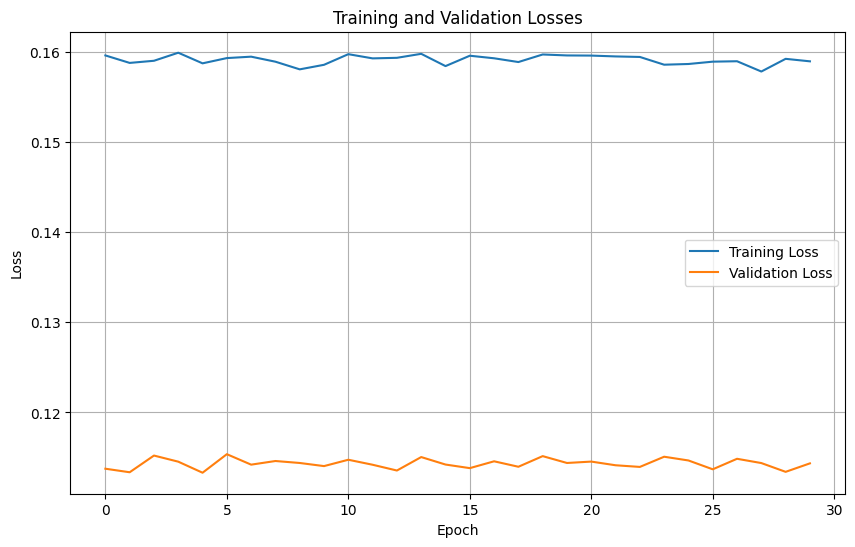

Evaluating model...


Evaluating:   0%|          | 0/15 [00:00<?, ?it/s]

Error comparing predictions for task 16b78196: a Tensor with 2 elements cannot be converted to Scalar
Error comparing predictions for task 28a6681f: a Tensor with 2 elements cannot be converted to Scalar
Error comparing predictions for task 409aa875: a Tensor with 2 elements cannot be converted to Scalar
Error comparing predictions for task 7491f3cf: a Tensor with 2 elements cannot be converted to Scalar
Error comparing predictions for task 7666fa5d: a Tensor with 2 elements cannot be converted to Scalar
Error comparing predictions for task 7c66cb00: a Tensor with 2 elements cannot be converted to Scalar
Error comparing predictions for task 8b9c3697: a Tensor with 2 elements cannot be converted to Scalar
Error comparing predictions for task 981571dc: a Tensor with 2 elements cannot be converted to Scalar
Error comparing predictions for task 9aaea919: a Tensor with 2 elements cannot be converted to Scalar
Error comparing predictions for task a395ee82: a Tensor with 2 elements cannot be 

Generating predictions:   0%|          | 0/240 [00:00<?, ?it/s]

Error generating predictions for test input 0 in task 00576224: Given input size: (32x1x1). Calculated output size: (32x0x0). Output size is too small
Error generating predictions for test input 0 in task 007bbfb7: Given input size: (32x1x1). Calculated output size: (32x0x0). Output size is too small
Error generating predictions for test input 0 in task 009d5c81: a Tensor with 2 elements cannot be converted to Scalar
Error generating predictions for test input 0 in task 017c7c7b: Given input size: (32x3x1). Calculated output size: (32x1x0). Output size is too small
Error generating predictions for test input 0 in task 03560426: a Tensor with 2 elements cannot be converted to Scalar
Error generating predictions for test input 0 in task 045e512c: a Tensor with 2 elements cannot be converted to Scalar
Error generating predictions for test input 0 in task 0520fde7: Given input size: (32x1x3). Calculated output size: (32x0x1). Output size is too small
Error generating predictions for test i

In [41]:
def main():
    """Main function to run the ARC-AGI-2 solution."""
    # Create datasets
    print("Creating datasets...")
    train_dataset = ARCDataset(train_challenges, train_solutions)
    eval_dataset = ARCDataset(eval_challenges, eval_solutions)
    
    # Create data loaders
    print("Creating data loaders...")
    train_loader = DataLoader(
        train_dataset, 
        batch_size=8,  # Adjust based on available GPU memory
        shuffle=True, 
        collate_fn=collate_arc_batch
    )
    
    eval_loader = DataLoader(
        eval_dataset, 
        batch_size=8, 
        shuffle=False, 
        collate_fn=collate_arc_batch
    )
    
    # Initialize model
    print("Initializing model...")
    base_model = TransformationNetwork(
        encoder_dim=128,
        hidden_dim=256,
        max_output_size=(30, 30)
    ).to(device)
    
    maml_model = MAML(
        base_model,
        inner_lr=0.01,  # Learning rate for task adaptation
        meta_lr=0.001   # Learning rate for meta-learning
    )
    
    # Train the model
    print("Starting meta-training...")
    trained_model, training_losses, validation_losses = meta_train(
        maml_model, 
        train_loader, 
        eval_loader, 
        num_epochs=30,  # Reduced for faster execution, increase for better results
        inner_steps=5,
        log_interval=5
    )
    
    # Evaluate model
    print("Evaluating model...")
    accuracy = evaluate_model(trained_model, eval_loader, num_adaptation_steps=10)
    print(f"Final evaluation accuracy: {accuracy:.4f}")
    
    # Generate submission
    print("Generating submission...")
    generate_submission(trained_model, test_challenges)
    
    print("Done!")

if __name__ == "__main__":
    # Run the main function
    main()